In [1]:
#hivemind.ipynb
#
#by Joe Hahn
#jmh.datasciences@gmail.com
#3 March 2018
#
#This illustrates how to play the hivemind game...

In [2]:
#generate small sample of bucket_yields
N_buckets = 4
lag = 1
N_turns = 20
SNR = 1.1                       #signal/noise ratio
rn_seed = 14
from hivemind import *
np.random.seed(seed=rn_seed)
actual_bucket_yields, best_bucket, lagged_bucket_yields, weather, weather_onehot, bucket_yield_mean, \
    bucket_yield_sigma = make_bucket_yields(N_buckets, N_turns, SNR, lag)

Using TensorFlow backend.


In [3]:
#print actual_bucket_yields & note that best_bucket=1 for bucket having highest actual_bucket_yields
for idx in range(N_turns):
    print 'actual_bucket_yields = ', actual_bucket_yields[idx], 'best_bucket = ', best_bucket[idx]

actual_bucket_yields =  [ 0.          0.00155707 -0.00274039  0.00565763] best_bucket =  [ 0.  0.  0.  1.]
actual_bucket_yields =  [ 0.          0.00330989  0.00276882  0.00506664] best_bucket =  [ 0.  0.  0.  1.]
actual_bucket_yields =  [ 0.          0.00260652  0.00579083  0.00853607] best_bucket =  [ 0.  0.  0.  1.]
actual_bucket_yields =  [ 0.         -0.00119987 -0.00021855  0.00880094] best_bucket =  [ 0.  0.  0.  1.]
actual_bucket_yields =  [ 0.          0.00017922  0.00610507  0.0089685 ] best_bucket =  [ 0.  0.  0.  1.]
actual_bucket_yields =  [ 0.          0.00135119  0.00735315  0.00083518] best_bucket =  [ 0.  0.  1.  0.]
actual_bucket_yields =  [ 0.         -0.00106928 -0.00618294 -0.00956718] best_bucket =  [ 1.  0.  0.  0.]
actual_bucket_yields =  [ 0.          0.00015585  0.00845787  0.00356163] best_bucket =  [ 0.  0.  1.  0.]
actual_bucket_yields =  [ 0.         -0.00011855 -0.00323185 -0.00191733] best_bucket =  [ 1.  0.  0.  0.]
actual_bucket_yields =  [ 0.         

In [4]:
#print lagged_bucket_yields & note that lagged_bucket_yields is lagged by 1 record
for idx in range(N_turns):
    print 'lagged_bucket_yields = ', lagged_bucket_yields[idx], 'best_bucket = ', best_bucket[idx]

lagged_bucket_yields =  [ 0.          0.00153835  0.00356546 -0.00138705] best_bucket =  [ 0.  0.  0.  1.]
lagged_bucket_yields =  [ 0.          0.00155707 -0.00274039  0.00565763] best_bucket =  [ 0.  0.  0.  1.]
lagged_bucket_yields =  [ 0.          0.00330989  0.00276882  0.00506664] best_bucket =  [ 0.  0.  0.  1.]
lagged_bucket_yields =  [ 0.          0.00260652  0.00579083  0.00853607] best_bucket =  [ 0.  0.  0.  1.]
lagged_bucket_yields =  [ 0.         -0.00119987 -0.00021855  0.00880094] best_bucket =  [ 0.  0.  0.  1.]
lagged_bucket_yields =  [ 0.          0.00017922  0.00610507  0.0089685 ] best_bucket =  [ 0.  0.  1.  0.]
lagged_bucket_yields =  [ 0.          0.00135119  0.00735315  0.00083518] best_bucket =  [ 1.  0.  0.  0.]
lagged_bucket_yields =  [ 0.         -0.00106928 -0.00618294 -0.00956718] best_bucket =  [ 0.  0.  1.  0.]
lagged_bucket_yields =  [ 0.          0.00015585  0.00845787  0.00356163] best_bucket =  [ 1.  0.  0.  0.]
lagged_bucket_yields =  [ 0.         

In [5]:
#note that actual_bucket_yields tend to be negative during hot or stormy weather 
for idx in range(N_turns):
    print 'weather = ', weather[idx], '    weather_onehot = ', weather_onehot[idx], \
        'actl_byls = ', actual_bucket_yields[idx]

weather =  nominal     weather_onehot =  [ 0.  1.  0.] actl_byls =  [ 0.          0.00155707 -0.00274039  0.00565763]
weather =  nominal     weather_onehot =  [ 0.  1.  0.] actl_byls =  [ 0.          0.00330989  0.00276882  0.00506664]
weather =  nominal     weather_onehot =  [ 0.  1.  0.] actl_byls =  [ 0.          0.00260652  0.00579083  0.00853607]
weather =  nominal     weather_onehot =  [ 0.  1.  0.] actl_byls =  [ 0.         -0.00119987 -0.00021855  0.00880094]
weather =  nominal     weather_onehot =  [ 0.  1.  0.] actl_byls =  [ 0.          0.00017922  0.00610507  0.0089685 ]
weather =  nominal     weather_onehot =  [ 0.  1.  0.] actl_byls =  [ 0.          0.00135119  0.00735315  0.00083518]
weather =  hot     weather_onehot =  [ 1.  0.  0.] actl_byls =  [ 0.         -0.00106928 -0.00618294 -0.00956718]
weather =  nominal     weather_onehot =  [ 0.  1.  0.] actl_byls =  [ 0.          0.00015585  0.00845787  0.00356163]
weather =  nominal     weather_onehot =  [ 0.  1.  0.] actl_

In [6]:
#generate larger sample of bucket_yields
N_buckets = 60
lag = 1
N_turns = 100
rn_seed = 14
from hivemind import *
np.random.seed(seed=rn_seed)
actual_bucket_yields, best_bucket, lagged_bucket_yields, weather, weather_onehot, bucket_yield_mean, \
    bucket_yield_sigma = make_bucket_yields(N_buckets, N_turns, SNR, lag)

In [7]:
#prep matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

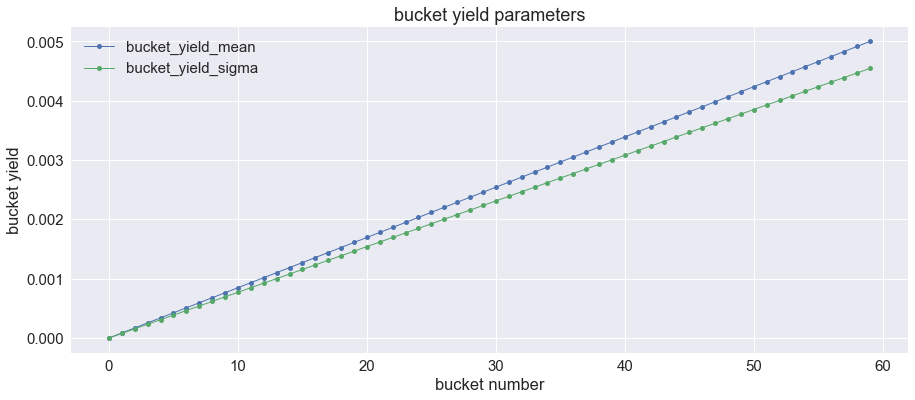

In [8]:
#plot loss vs training epoch...note that bucket_yield_mean has signal/noise=2
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = np.arange(N_buckets)
yp = bucket_yield_mean
ax.plot(xp, yp, linewidth=1, marker='o', markersize=5, label='bucket_yield_mean')
yp = bucket_yield_sigma
ax.plot(xp, yp, linewidth=1, marker='o', markersize=5, label='bucket_yield_sigma')
ax.set_title('bucket yield parameters')
ax.set_ylabel('bucket yield')
ax.set_xlabel('bucket number')
ax.legend()

In [9]:
#play single small game and compute net_values vs turn
strategy = 'high'
N_buckets = 6
SNR = 1.1
lag = 1
N_turns = 100
actual_bucket_yields, best_bucket, lagged_bucket_yields, weather, weather_onehot, bucket_yield_mean, \
    bucket_yield_sigma = make_bucket_yields(N_buckets, N_turns, SNR, lag)
net_values = compute_net_value(actual_bucket_yields, lagged_bucket_yields, weather, weather_onehot, strategy)
net_values.tail()

,yield0,yield1,yield2,yield3,yield4,yield5,net_value,prob0,prob1,prob2,prob3,prob4,prob5,compound_value,turn,weather
95,0.0,0.000058,0.002964,-0.001420,0.003420,-0.000409,1.001505,0.0,0.0,0.0,0.0,0.5,0.5,1.366170,95,nominal
96,0.0,0.000133,-0.000448,0.003115,0.005114,0.007770,1.006442,0.0,0.0,0.0,0.0,0.5,0.5,1.374970,96,nominal
97,0.0,0.000892,0.002589,0.004856,0.008945,-0.001932,1.003506,0.0,0.0,0.0,0.0,0.5,0.5,1.379791,97,nominal
98,0.0,0.001521,0.001372,0.006985,0.003424,0.005534,1.004479,0.0,0.0,0.0,0.0,0.5,0.5,1.385971,98,nominal
99,0.0,0.002166,0.003054,0.003308,0.000603,0.012884,1.006743,0.0,0.0,0.0,0.0,0.5,0.5,1.395317,99,nominal


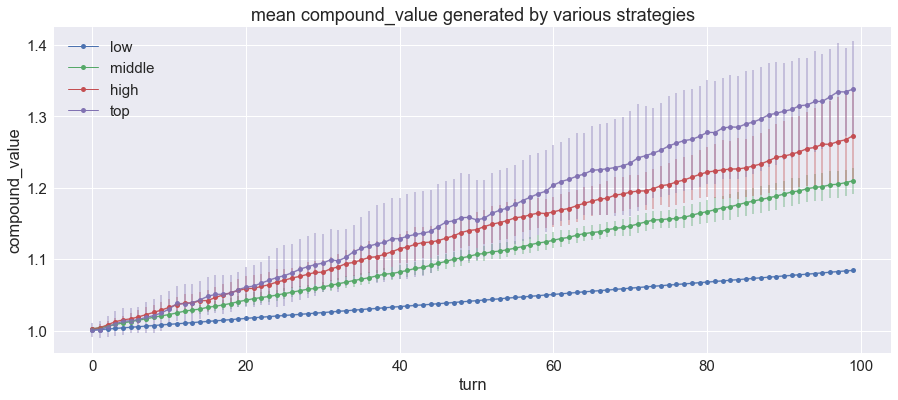

In [10]:
#play 10 games per each strategy and plot their average compound_value vs turn
N_games = 10
N_buckets = 60
lag = 1
N_turns = 100
strategies = ['low', 'middle', 'high', 'top']
fig, ax = plt.subplots(1,1, figsize=(15, 6))
all_net_values = pd.DataFrame()
for strategy in strategies:
    for idx in range(N_games):
        actual_bucket_yields, _, lagged_bucket_yields, _, _, _, _ = make_bucket_yields(N_buckets, N_turns, SNR, lag)
        net_values = compute_net_value(actual_bucket_yields, lagged_bucket_yields, weather, weather_onehot, \
            strategy, model=None)
        net_values['strategy'] = strategy
        all_net_values = all_net_values.append(net_values, ignore_index=True)
g = all_net_values.groupby(['strategy', 'turn'], as_index=False)['compound_value'].agg(['mean', 'std', 'count'])
for strategy in strategies:
    strategy_results = g.loc[strategy]
    xp = strategy_results.index
    yp = strategy_results['mean'].values
    yerr = strategy_results['std'].values
    p = ax.plot(xp, yp, linewidth=1, marker='o', markersize=5, label=strategy)
    p = ax.errorbar(xp, yp, yerr=yerr, alpha=0.4, color=p[0].get_color())
p = ax.set_title('mean compound_value generated by various strategies')
p = ax.set_ylabel('compound_value')
p = ax.set_xlabel('turn')
p = ax.legend()

In [11]:
#generate lots of test-train-validate data: lagged_bucket_yields and best_bucket
N_buckets = 60
lag = 1
SNR = 1.1
N_turns = 100000
actual_bucket_yields, best_bucket, lagged_bucket_yields, weather, weather_onehot, bucket_yield_mean, \
    bucket_yield_sigma = make_bucket_yields(N_buckets, N_turns, SNR, lag)

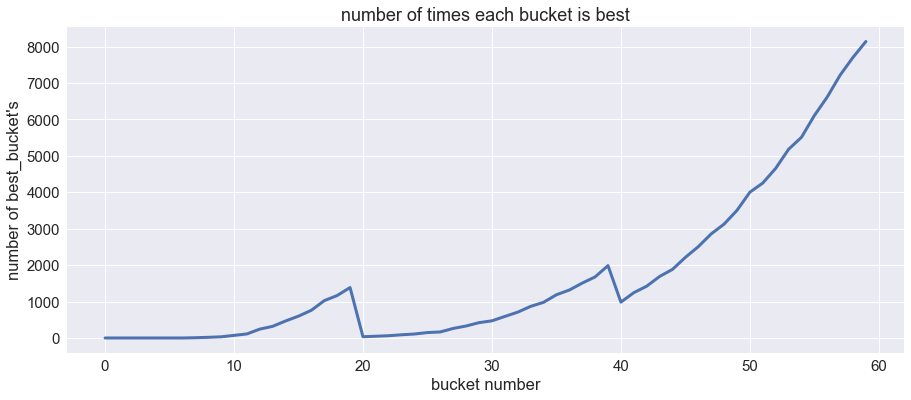

In [12]:
#check class imbalance
idx = (weather == 'nominal')
yp = best_bucket.sum(axis=0)
xp = np.arange(len(yp))
fig, ax = plt.subplots(1,1, figsize=(15, 6))
p = ax.plot(xp, yp, linewidth=3)
p = ax.set_title('number of times each bucket is best')
p = ax.set_ylabel("number of best_bucket's")
p = ax.set_xlabel('bucket number')

In [13]:
#features x = lagged_bucket_yields + weather_onehot
x = np.concatenate((lagged_bucket_yields, weather_onehot), axis=1)
idx = 4
print 'lagged_bucket_yields = ', lagged_bucket_yields[idx]
print 'weather_onehot = ', weather_onehot[idx]
print 'x = ', x[idx]
#target y = best_bucket
y = best_bucket
print 'y = ', y[idx]

lagged_bucket_yields =  [  0.00000000e+00   1.03307542e-04   2.15713157e-04  -2.75139948e-05
   2.93704453e-04   1.68775157e-04   2.23578228e-04   9.80735615e-04
   1.02211456e-03   2.04737317e-04  -3.51738322e-04   6.75583171e-04
  -1.83503716e-04   1.11648478e-03   7.17180499e-04  -1.47842417e-03
   3.68134220e-03   1.27022979e-03   5.26615467e-03   2.25862711e-03
   3.74629661e-04   2.76713843e-03   4.88418994e-05   1.46863270e-04
   3.04052156e-03   2.32903181e-03   3.45344565e-03   3.02302666e-04
   2.90877430e-03   2.84265331e-03  -5.87289465e-04   2.99403959e-03
   8.45665182e-04  -4.78681411e-05   2.88045027e-03   2.32102651e-03
   4.99623143e-03   7.70906305e-03   5.92158128e-03   5.62923805e-03
   3.43995429e-03   6.21051623e-04   7.64848367e-03  -7.38258948e-04
   1.75563352e-03   6.29191556e-04   3.75228306e-03   5.07753171e-03
   5.09242104e-03   1.54542405e-03   8.24233693e-03  -1.47631794e-03
   1.11198586e-02  -2.32624804e-04   3.46092201e-04   6.32338712e-03
   2.17747

In [14]:
#test-train-validation split is 1:1:1
train_fraction = 0.333
from sklearn.model_selection import train_test_split
x_train, x_test_validate, y_train, y_test_validate = train_test_split(x, y, train_size=train_fraction, 
    test_size=(1-train_fraction), random_state=rn_seed)
train_fraction = 0.5
x_test, x_validate, y_test, y_validate = \
    train_test_split(x_test_validate, y_test_validate, train_size=train_fraction, random_state=rn_seed)
print x.shape, y.shape
print x_train.shape, y_train.shape
print x_test.shape, y_test.shape
print x_validate.shape, y_validate.shape

(100000, 63) (100000, 60)
(33300, 63) (33300, 60)
(33350, 63) (33350, 60)
(33350, 63) (33350, 60)


/Users/joe/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [15]:
#build MLP classification model 
N_inputs = x.shape[1]
N_outputs = y.shape[1]
N_middle_layer = 0*N_outputs
dropout_fraction = 0.0
model = mlp_classifier(N_inputs, N_middle_layer, N_outputs, dropout_fraction)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 63)                4032      
_________________________________________________________________
dropout_1 (Dropout)          (None, 63)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                3840      
Total params: 7,872
Trainable params: 7,872
Non-trainable params: 0
_________________________________________________________________


In [16]:
#fit model to predict most productive bucket
N_epochs = 25
batch_size = N_turns/100
print 'layers = ', N_inputs, N_middle_layer, N_outputs
print 'dropout_fraction = ', dropout_fraction
model = mlp_classifier(N_inputs, N_middle_layer, N_outputs, dropout_fraction)
fit_history = model.fit(x_train, y_train, batch_size=batch_size, epochs=N_epochs, verbose=0, 
    validation_data=(x_validate, y_validate))

layers =  63 0 60
dropout_fraction =  0.0


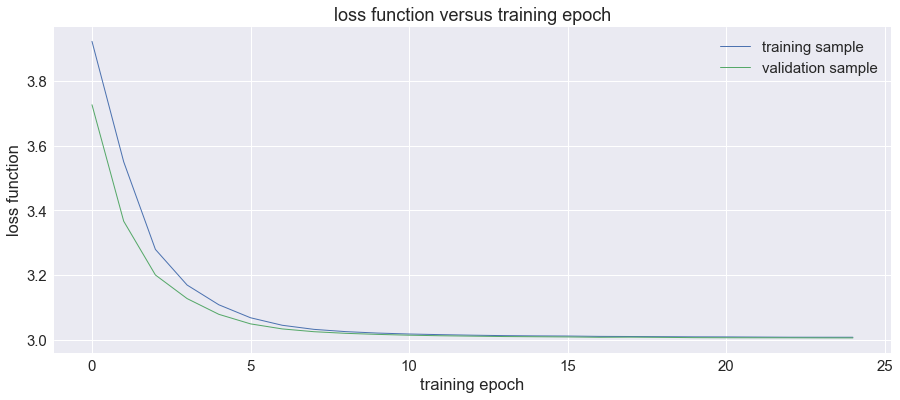

In [17]:
#plot loss vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
p = ax.plot(xp, yp, linewidth=1, label='training sample')
yp = fit_history.history['val_loss']
p = ax.plot(xp, yp, linewidth=1, label='validation sample')
p = ax.set_title('loss function versus training epoch')
p = ax.set_ylabel('loss function')
p = ax.set_xlabel('training epoch')
p = ax.legend()

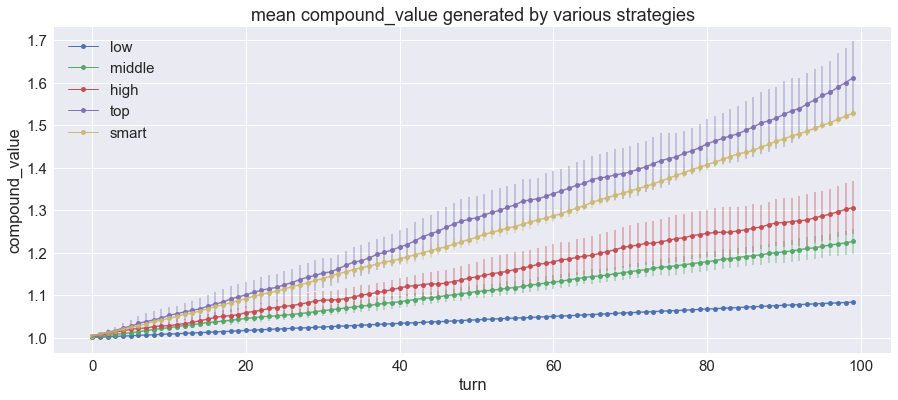

In [18]:
#play 10 short games using each strategy and plot their mean compound_value
N_games = 10
N_turns = 100
top_k = 6
strategies = ['low', 'middle', 'high', 'top', 'smart']
fig, ax = plt.subplots(1,1, figsize=(15, 6))
all_net_values = pd.DataFrame()
for strategy in strategies:
    for idx in range(N_games):
        actual_bucket_yields, best_bucket, lagged_bucket_yields, weather, weather_onehot, bucket_yield_mean, \
            bucket_yield_sigma = make_bucket_yields(N_buckets, N_turns, SNR, lag)
        net_values = compute_net_value(actual_bucket_yields, lagged_bucket_yields, weather, weather_onehot, \
            strategy, model=model, top_k=top_k)
        net_values['strategy'] = strategy
        all_net_values = all_net_values.append(net_values, ignore_index=True)
g = all_net_values.groupby(['strategy', 'turn'], as_index=False)['compound_value'].agg(['mean', 'std', 'count'])
weathers = np.unique(weather)
for strategy in strategies:
    strategy_results = g.loc[strategy]
    xp = strategy_results.index
    yp = strategy_results['mean'].values
    yerr = strategy_results['std'].values
    p = ax.plot(xp, yp, linewidth=1, marker='o', markersize=5, label=strategy)
    p = ax.errorbar(xp, yp, yerr=yerr, alpha=0.4, color=p[0].get_color())
    if (strategy == 'top'):
        compound_value_err_top = yerr
    if (strategy == 'smart'):
        compound_value_err_smart = yerr
p = ax.set_title('mean compound_value generated by various strategies')
p = ax.set_ylabel('compound_value')
p = ax.set_xlabel('turn')
p = ax.legend()

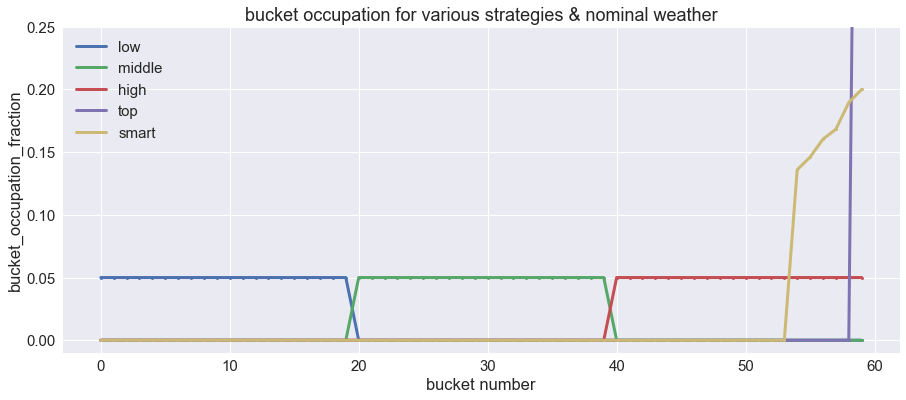

In [19]:
#plot each strategy's bucket_occupation_fraction during nominal weather
the_weather = 'nominal'
cols = ['strategy', 'weather'] + [col for col in all_net_values.columns if ('prob' in col)]
df = all_net_values[cols]
avg = df.groupby(['strategy', 'weather']).mean()
std = df.groupby(['strategy', 'weather']).std()
count = df.groupby(['strategy', 'weather'], as_index=False).count()
fig, ax = plt.subplots(1,1, figsize=(15, 6))
for strategy in strategies:
    yp = avg.loc[strategy].loc[the_weather]
    yerr = std.loc[strategy].loc[the_weather]
    xp = np.arange(len(yp))
    p = ax.plot(xp, yp, linewidth=3, marker='o', markersize=3, label=strategy)
p = ax.set_title('bucket occupation for various strategies & nominal weather')
p = ax.set_ylabel('bucket_occupation_fraction')
p = ax.set_xlabel('bucket number')
p = ax.set_ylim(-0.01, 0.25)
p = ax.set_yscale('linear')
p = ax.legend()

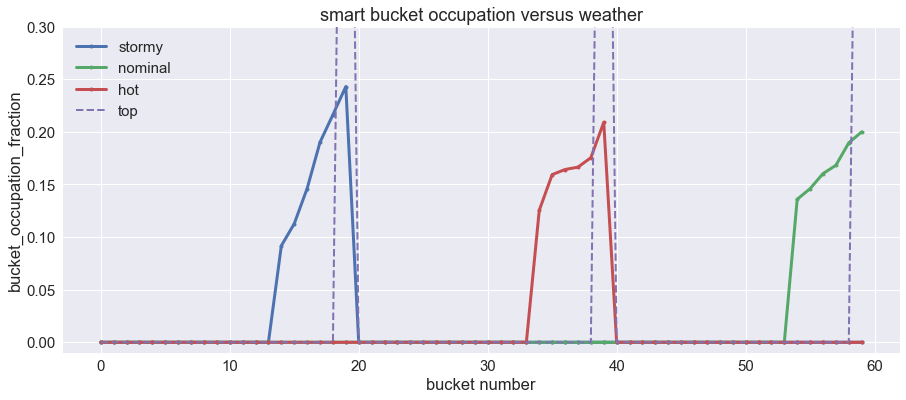

In [20]:
#plot smart bucket_occupation_fraction for each weather
strategy = 'smart'
fig, ax = plt.subplots(1,1, figsize=(15, 6))
for the_weather in ['stormy', 'nominal', 'hot']:
    yp = avg.loc[strategy].loc[the_weather]
    yerr = std.loc[strategy].loc[the_weather]
    xp = np.arange(len(yp))
    p = ax.plot(xp, yp, linewidth=3, marker='o', markersize=4, label=the_weather)
strategy = 'top'
yp = avg.loc[strategy].sum()
xp = np.arange(len(yp))
p = ax.plot(xp, yp, linewidth=2, linestyle='--', label=strategy)
p = ax.set_title('smart bucket occupation versus weather')
p = ax.set_ylabel('bucket_occupation_fraction')
p = ax.set_xlabel('bucket number')
p = ax.set_ylim(-0.01, 0.3)
p = ax.set_yscale('linear')
p = ax.legend()

mean =  0.265106812164 0.408248290464


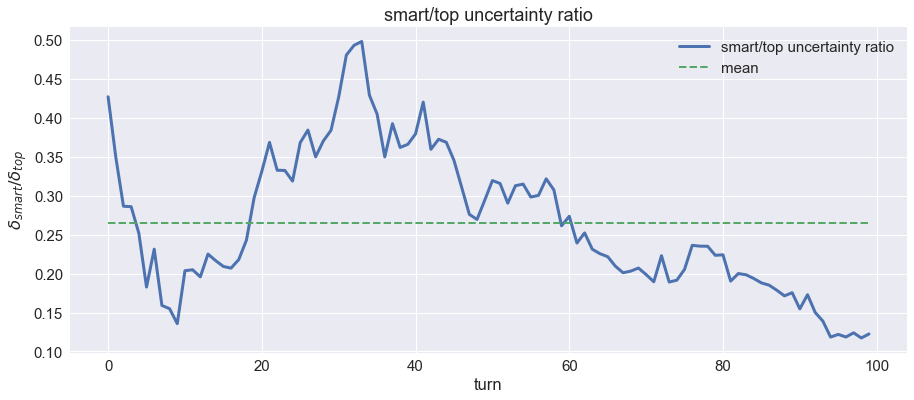

In [21]:
#plot loss vs training epoch
yp = compound_value_err_smart/compound_value_err_top
xp = range(len(yp))
fig, ax = plt.subplots(1,1, figsize=(15, 6))
p = ax.plot(xp, yp, linewidth=3, label='smart/top uncertainty ratio')
yp_avg = yp.mean()
p = ax.plot(xp, yp*0 + yp_avg, linewidth=2, linestyle='--', label='mean')
p = ax.set_title('smart/top uncertainty ratio')
p = ax.set_ylabel(r'$\delta_{smart}/\delta_{top}$')
p = ax.set_xlabel('turn')
p = ax.legend()
print 'mean = ', yp_avg, 1.0/np.sqrt(top_k)